# Sentinel-2 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
    * One step of the analysis ('Sentinel-2 Near Real Time') is currently only compatible with the DEA Sandbox
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule)


## Background

Sentinel-2 is an Earth observation mission from the EU Copernicus Programme that systematically acquires optical imagery at high spatial resolution (up to 10 m for some bands).
The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery.
Together, they cover all Earth's land surfaces, large islands, inland and coastal waters every 3-5 days.

Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.
Both of the Sentinel-2 satellites carry an innovative wide swath high-resolution multispectral imager with 13 spectral bands.
For more information on the Sentinel-2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Applications/Observing_the_Earth/Copernicus/Overview4).

Digital Earth Australia (DEA) applies corrections to Sentinel-2 satellite images to arrive at a [surface reflectance](https://cmi.ga.gov.au/ga_s2_m_nbart_1) product (see the [introduction to Digtial Earth Australia](../Beginners_guide/02_DEA.ipynb) section for more information on the surface reflectance corrections).
Surface reflectance provides standardised optical datasets by using robust physical models to correct for variations in image radiance values due to atmospheric properties, as well as sun and sensor geometry.
The resulting stack of surface reflectance grids are consistent over space and time, which is instrumental in identifying and quantifying environmental change.

DEA provides two Sentinel-2 surface reflectance products:

1. **Sentinel-2 Definitive** (e.g. `s2a_ard_granule`): These products represent the 'definitive' source of high quality Sentinel-2 surface reflectance data, and are available from the beginning of the Sentinel-2 archive up to a delay of several weeks. 

2. **Sentinel-2 Near Real Time** (e.g. `s2a_nrt_granule`): These products are processed with best-available ancillary information and provided as a rolling 90 day archive of imagery which is typically available to load within approximately ~24 hours of a satellite overpass.

Both Sentinel-2 Definitive and Sentinel-2 Near Real Time products contain data processed to two surface reflectance corrections, however only NBART data is available on the DEA Sandbox:

1. **NBAR** (e.g. `nbar_green`): Radiance data collected by Sentinel-2 can be affected by atmospheric conditions, sun position, sensor view angle, surface slope and surface aspect. 
These need to be reduced or removed to ensure the data can be compared consistently over time and space to identify and quantify environmental change.
NBAR data (i.e. measurements with the `nbar_` prefix above) takes Sentinel-2 imagery captured over the Australian continent and corrects inconsistencies using Nadir corrected Bi-directional reflectance distribution function Adjusted Reflectance (NBAR).

> **Note:** NBAR data is currently only available in the [NCI environment](https://docs.dea.ga.gov.au/setup/NCI/README.html), not the [DEA Sandbox environment](https://docs.dea.ga.gov.au/setup/sandbox.html).

2. **NBART** (e.g. `nbart_green`): NBART data (i.e. measurements with the `nbart_` prefix) are also processed using NBAR, but have an additional terrain illumination correction applied using a Digital Surface Model (DSM) to correct for varying terrain. NBART is typically the default choice for most analyses as removing terrain illumination and shadows allows changes in the landscape to be compared more consistently across time.


Sentinel-2 surface reflectance products have 13 spectral channels:

| Sentinel-2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `nbar(t)_coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `nbar(t)_blue` | 2 | 490 | 10 | 65 |
| Green | `nbar(t)_green` | 3 | 560 | 10 | 35 |
| Red | `nbar(t)_red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `nbar(t)_red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nbar(t)_nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nbar(t)_nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `nbar(t)_swir_2` | 11 | 1610 | 20 | 90 |
| SWIR | `nbar(t)_swir_3` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

!['Sentinel-2 spectral bands'](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)
     
> **Note**: There are a number of additional datasets that are also returned as part of Sentinel-2 queries.
These are a combination of datasets used in the correction process, and layers relating to pixel quality.

## Description

This notebook will run through loading in Sentinel-2A and Sentinel-2B satellite images.
Topics covered include:

* Using the native `dc.load()` function to load in Sentinel-2 Definitive data from a single Sentinel-2 satellite
* Using the `load_ard()` wrapper function to load in a concatenated, sorted, and cloud masked time series from both Sentinel-2A and 2B
* Loading the latest available Sentinel-2 imagery from the Sentinel-2 Near Real Time products

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import sys
import datacube
from odc.ui import with_ui_cbk

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Sentinel_2")

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Load Sentinel-2 data from the datacube

We will load **Sentinel-2 Definitive** data from the Sentinel-2A and Sentinel-2B satellites using two methods.
Firstly, we will use [dc.load()](../Beginners_guide/04_Loading_data.ipynb) to return a time series of satellite images from a single sensor.
Secondly, we will load a time series using the [load_ard()](../Frequently_used_code/Using_load_ard.ipynb) function, which is a wrapper function around the dc.load module.
This function will load all the images from both Sentinel-2A and Sentinel-2B, combine them, and then apply a cloud mask.
The returned `xarray.Dataset` will contain analysis ready images with the cloudy and invalid pixels masked out.

You can change any of the parameters in the `query` object below to adjust the location, time, projection, or spatial resolution of the returned datasets.
To learn more about querying, refer to the Beginner's guide notebook on [loading data](../Beginners_guide/04_Loading_data.ipynb).

Sentinel-2 data is stored on file with a range of different coordinate reference systems or CRS (i.e. multiple UTM zones). 
The different satellite bands also have different resolutions (10 m, 20 m and 60 m). 
Because of this, all Sentinel-2 queries need to include the following two query parameters:

* `output_crs`: This sets a consistent CRS that all Sentinel-2 data will be reprojected to, regardless of the UTM zone the individual image is stored in.
* `resolution`: This sets the resolution that all Sentinel-2 images will be resampled to. 

> **Note:** Be aware that setting `resolution` to the highest available resolution (i.e. `(-10, 10)`) will downsample the coarser resolution 20 m and 60 m bands, which may introduce unintended artefacts into your analysis.
It is typically best practice to set `resolution` to match the lowest resolution band being analysed. For example, if your analysis uses both 10 m and 20 m resolution bands, set `"resolution": (-20, 20)`.

In [3]:
# Create a query object
query = {
    "x": (153.45, 153.47),
    "y": (-28.90, -28.92),
    "time": ("2018-01", "2018-02"),
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10),
    "group_by": "solar_day",
}

### Load Sentinel-2 using `dc.load()`

The two **Sentinel-2 Definitive** products are:

* `s2a_ard_granule`
* `s2b_ard_granule`

Here we will load in a time-series of satellite images from only Sentinel-2A.
To load in images from Sentinel-2B, change the `product` variable to `'s2b_ard_granule'`.

In [4]:
ds = dc.load(product="s2a_ard_granule",
             progress_cbk=with_ui_cbk(),
             **query)

ds

<xarray.Dataset>
Dimensions:                (time: 6, x: 228, y: 255)
Coordinates:
  * time                   (time) datetime64[ns] 2018-01-06T23:52:37.461000 ....
  * y                      (y) float64 -3.313e+06 -3.313e+06 ... -3.316e+06
  * x                      (x) float64 2.057e+06 2.057e+06 ... 2.059e+06
    spatial_ref            int32 3577
Data variables:
    azimuthal_exiting      (time, y, x) float32 -160.90376 ... -29.190119
    azimuthal_incident     (time, y, x) float32 170.4605 ... -25.479986
    exiting                (time, y, x) float32 1.9511385 2.391956 ... 5.8774323
    incident               (time, y, x) float32 25.019077 25.188375 ... 38.39617
    relative_azimuth       (time, y, x) float32 16.493828 ... 37.642647
    relative_slope         (time, y, x) float32 -28.635742 ... 3.7101326
    satellite_azimuth      (time, y, x) float32 99.85303 99.85302 ... 99.85423
    satellite_view         (time, y, x) float32 4.5394645 ... 4.2476106
    solar_azimuth          (time, y, x) float32 83.3592 83.35906 ... 62.211586
    solar_zenith           (time, y, x) float32 27.643938 27.643759 ... 35.8065
    terrain_shadow         (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    fmask                  (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2
    nbart_contiguity       (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    nbart_coastal_aerosol  (time, y, x) int16 333 333 333 333 ... 1914 1914 2132
    nbart_blue             (time, y, x) int16 256 299 320 317 ... 1696 1811 1863
    nbart_green            (time, y, x) int16 508 602 638 671 ... 1849 1919 1912
    nbart_red              (time, y, x) int16 255 283 298 301 ... 1742 1786 1803
    nbart_red_edge_1       (time, y, x) int16 751 903 903 934 ... 2271 2271 2322
    nbart_red_edge_2       (time, y, x) int16 2598 3061 3061 ... 3229 3229 3202
    nbart_red_edge_3       (time, y, x) int16 3586 4023 4023 ... 3700 3700 3582
    nbart_nir_1            (time, y, x) int16 4301 4249 4246 ... 3994 4041 3970
    nbart_nir_2            (time, y, x) int16 4148 4475 4475 ... 3967 3967 3905
    nbart_swir_2           (time, y, x) int16 1596 1764 1764 ... 2733 2733 2742
    nbart_swir_3           (time, y, x) int16 605 706 706 691 ... 2293 2293 2340
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

The returned dataset contains all of the bands available for Sentinel-2.
These include both `NBAR` and `NBAR-T` versions of the optical bands, along with [fmask](../Frequently_used_code/Masking_data.ipynb) (used for cloud masking) and other measurements (e.g. `azimuthal_exiting`, `azimuthal_incident`) that are used for generating the surface reflectance product.

Usually we are not interested in returning all the possible bands, but instead are only interested in a subset of these.
If we wished to return only a few of `NBAR-T` optical bands, then we would pass a `measurements` parameter to `dc.load()` (or, alternatively, amend the initial `query` object to have a `measurements` parameter). 

In [5]:
bands = ["nbart_blue", "nbart_green", "nbart_red"]

ds = dc.load(product="s2a_ard_granule",
             measurements=bands,
             progress_cbk=with_ui_cbk(),
             **query)

ds

<xarray.Dataset>
Dimensions:      (time: 6, x: 228, y: 255)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-06T23:52:37.461000 ... 2018-02...
  * y            (y) float64 -3.313e+06 -3.313e+06 ... -3.316e+06 -3.316e+06
  * x            (x) float64 2.057e+06 2.057e+06 ... 2.059e+06 2.059e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (time, y, x) int16 256 299 320 317 312 ... 1611 1696 1811 1863
    nbart_green  (time, y, x) int16 508 602 638 671 654 ... 1802 1849 1919 1912
    nbart_red    (time, y, x) int16 255 283 298 301 298 ... 1711 1742 1786 1803
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

Once the load is complete, we can then analyse or plot the Sentinel-2 data:

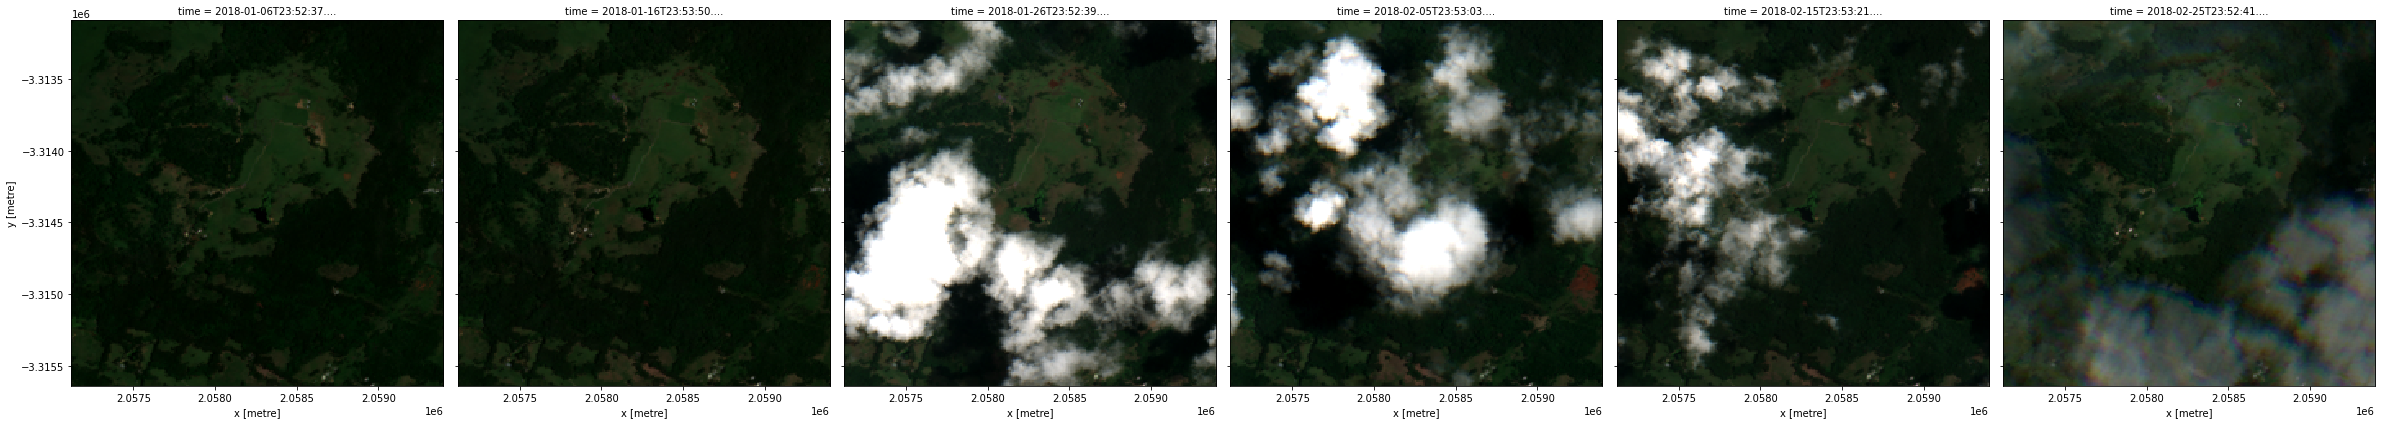

In [6]:
rgb(ds, col="time", col_wrap=6)

### Load Sentinel-2 using `load_ard`

This function will load images from both Sentinel-2A and Sentinel-2B, concatenate and sort the observations by time, and apply a cloud mask.
The result is an analysis ready dataset.
You can find more information on this function from the [Using load ard](../Frequently_used_code/Using_load_ard.ipynb) notebook.

In [7]:
ds = load_ard(dc=dc,
              products=["s2a_ard_granule", "s2b_ard_granule"],
              measurements=bands,
              **query)

print(ds)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Applying pixel quality/cloud mask
Loading 12 time steps
<xarray.Dataset>
Dimensions:      (time: 12, x: 228, y: 255)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:53:47.615000 ... 2018-02...
  * y            (y) float64 -3.313e+06 -3.313e+06 ... -3.316e+06 -3.316e+06
  * x            (x) float64 2.057e+06 2.057e+06 ... 2.059e+06 2.059e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


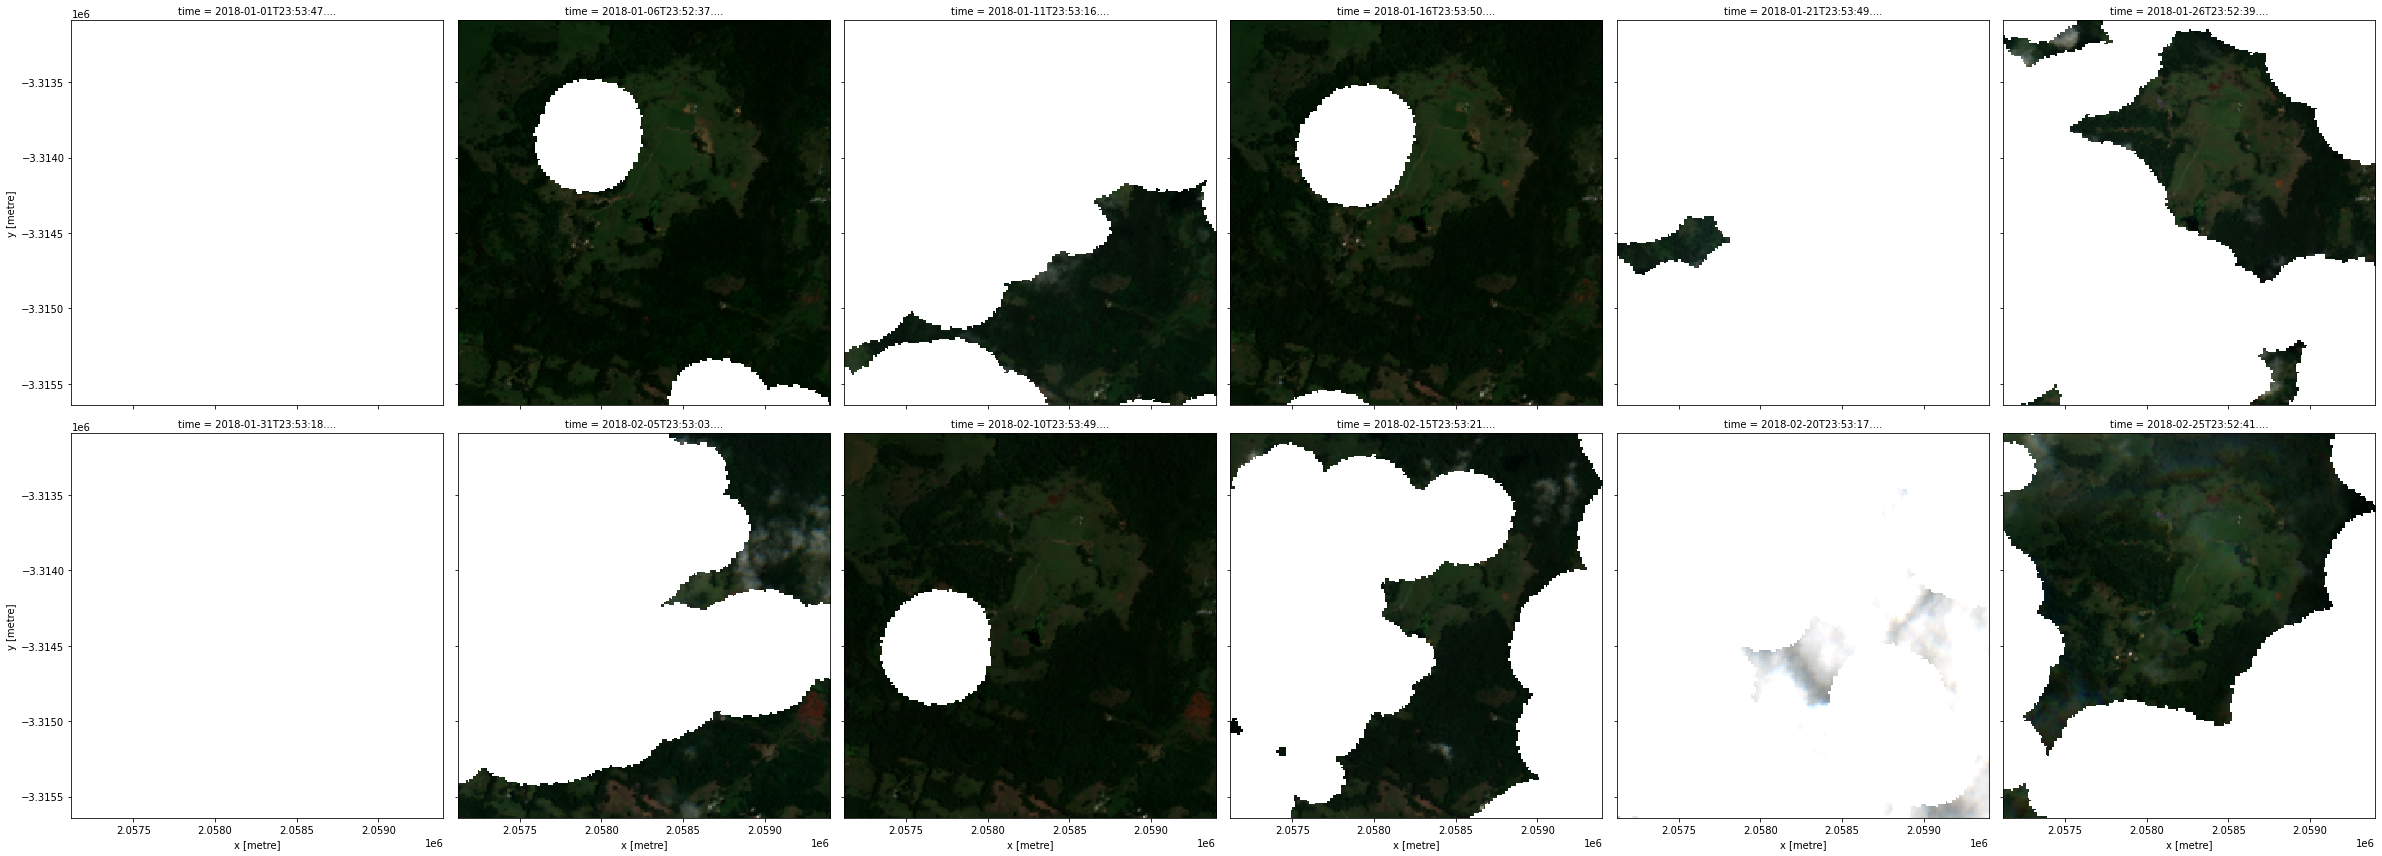

In [8]:
rgb(ds, col='time', col_wrap=6)

## Sentinel-2 Near Real Time

> **Note:** Sentinel-2 Near Real Time is only currently only available to load via the [DEA Sandbox environment](https://docs.dea.ga.gov.au/setup/sandbox.html)

The surface reflectance processing workflow for Sentinel-2 Definitive products typically causes a delay before this data is available to load through the datacube.

To address this delay, DEA also provides a **Sentinel-2 Near Real Time** product which is available to load as early as ~24 hours after a satellite observation is made. 
Near Real Time data is processed using best-available ancillary information to provide atmospheric corrections, and delivered as a rolling 90 day archive of imagery.

The two Sentinel-2 Near Real Time products are:

* `s2a_nrt_granule`
* `s2b_nrt_granule`

We can load this data using either `dc.load()` or `load_ard()` using the [methods demonstrated above](#Load-Sentinel-2-data-from-the-datacube):

In [9]:
# Create a query object
query = {
    "x": (153.45, 153.47),
    "y": (-28.90, -28.92),
    "measurements": ["nbart_blue", "nbart_green", "nbart_red"],
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10),
    "group_by": "solar_day",
}

ds = load_ard(dc=dc,
              products=["s2a_nrt_granule", "s2b_nrt_granule"],
              mask_pixel_quality=False,
              **query)


Finding datasets
    s2a_nrt_granule
    s2b_nrt_granule
Loading 17 time steps


We can now plot the most recently acquired Sentinel-2 image for our query region:

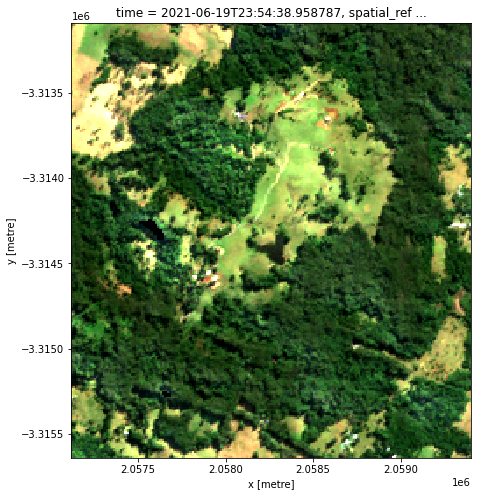

In [10]:
# `index=-1` selects the final image in the dataset
rgb(ds, index=-1, size=8)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2021

**Compatible datacube version:** 

In [11]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)